In [36]:
pip install mediapipe

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [37]:
import os
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
import mediapipe as mp
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [38]:
print("Initializing.....")

# MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh

face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# These are the eye region points
eye_indices = [63, 117, 293, 346, 9] 

# Method to extract the eye region
def extract_eye_region(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Process the image to get facial landmarks
    results = face_mesh.process(image_rgb)
    
    if results.multi_face_landmarks: # if the faical landmarks exist
        for landmarks in results.multi_face_landmarks:

            eye_points = [(landmarks.landmark[i].x, landmarks.landmark[i].y) for i in eye_indices]
            
            h, w, _ = image.shape
            eye_points_px = [(int(point[0] * w), int(point[1] * h)) for point in eye_points]
            
            # Landmarks
            #print("Eye Landmark Points (Pixel Coordinates):")
            #for i, point in zip(eye_indices, eye_points_px):
                #print(f"Landmark {i}: {point}")
            
            # Extract the x and y components of the points
            xi, yi = eye_points_px[0]  # p63
            xf, yf = eye_points_px[3]  # p346

            # Calculating the distances between the points
            d1 = int(np.linalg.norm(np.array(eye_points_px[0]) - np.array(eye_points_px[4])))  # p63 to p9
            d2 = int(np.linalg.norm(np.array(eye_points_px[4]) - np.array(eye_points_px[2])))  # p9 to p293
            d3 = int(np.linalg.norm(np.array(eye_points_px[2]) - np.array(eye_points_px[3])))  # p293 to p346
            d4 = int(np.linalg.norm(np.array(eye_points_px[0]) - np.array(eye_points_px[1])))  # p63 to p117
            
            #print(f"Distances - d1: {d1}, d2: {d2}, d3: {d3}, d4: {d4}")
            
            # Bounding box around the eyes
            x_min = min(point[0] for point in eye_points_px)
            x_max = max(point[0] for point in eye_points_px)
            y_min = min(point[1] for point in eye_points_px)
            y_max = max(point[1] for point in eye_points_px)
            
            padding = 10 # Adding padding here
            x_min = max(0, x_min - padding)
            y_min = max(0, y_min - padding)
            x_max = min(w, x_max + padding)
            y_max = min(h, y_max + padding)
            
            # Create a copy of the image to draw landmarks
            image2 = image.copy()
            
            # Draw the landmarks on the image
            for point in eye_points_px:
                cv2.circle(image2, point, 5, (0, 255, 0), -1)
            
            # Drawing the bounding box
            cv2.rectangle(image2, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
            
            #cv2.imshow(image2)
            #cv2.waitKey(0)
            
            # Cropping the eye region
            ROI = image[y_min:y_max, x_min:x_max]
            
            return ROI

    return None

def get_images(dir_path, img_list):
    for subdir, _, images in os.walk(dir_path):
        for img in images:
            # Create full path and add to the list
            image_path = os.path.join(subdir, img)
            img_list.append(image_path)
    return img_list

# Prepare dataset
path = "/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/"
drowsy_list = []
non_drowsy_list = []
drowsy_path = os.path.join(path, "Drowsy")
non_drowsy_path = os.path.join(path, "Non Drowsy")
get_images(drowsy_path, drowsy_list)
get_images(non_drowsy_path, non_drowsy_list)

drowsy_labels = [1] * len(drowsy_list)
non_drowsy_labels = [0] * len(non_drowsy_list)

# Combine image paths and labels
images_list = drowsy_list + non_drowsy_list
labels = drowsy_labels + non_drowsy_labels
size = len(images_list)

for img_path in images_list:
    img = cv2.imread(img_path)
    
    eye_region = extract_eye_region(img)

    if eye_region is not None:
        # Saving the image back to the same path
        cv2.imwrite(img_path, eye_region)


# Splitting the dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(
    images_list, labels, test_size=0.2, random_state=42, stratify=labels
)

val_size = 0.2
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=val_size, random_state=42, stratify=train_labels
)

# Print dataset information
print("Number of images in total:", size)
print("Number of images in training set:", len(train_paths))
print("Number of images in validation set:", len(val_paths))
print("Number of images in test set:", len(test_paths))

# preprocessing
def preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [224, 224])  #resizing to 244x244
    img = tf.cast(img, tf.float32) / 255.0  #normalization to [0,1]
    return img, label

    
batch_size = 32

#Creating the training set
train_set = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_set = train_set.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_set = train_set.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

#Creating the validation set
validation_set = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
validation_set = validation_set.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
validation_set = validation_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)

#creating the test set
test_set = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_set = test_set.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_set = test_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)


Initializing.....


W0000 00:00:1732094240.623197    2826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732094240.634311    2823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Number of images in total: 41793
Number of images in training set: 26747
Number of images in validation set: 6687
Number of images in test set: 8359


Epoch 1/20
836/836 ━━━━━━━━━━━━━━━━━━━━ 60s 62ms/step - accuracy: 0.9318 - loss: 0.9895 - val_accuracy: 0.9979 - val_loss: 0.1064
Epoch 2/20
836/836 ━━━━━━━━━━━━━━━━━━━━ 47s 55ms/step - accuracy: 0.9937 - loss: 0.1017 - val_accuracy: 0.9973 - val_loss: 0.0706
Epoch 3/20
836/836 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - accuracy: 0.9950 - loss: 0.0771 - val_accuracy: 0.9988 - val_loss: 0.0485
Epoch 4/20
836/836 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - accuracy: 0.9960 - loss: 0.0650 - val_accuracy: 0.9993 - val_loss: 0.0465
Epoch 5/20
836/836 ━━━━━━━━━━━━━━━━━━━━ 46s 54ms/step - accuracy: 0.9952 - loss: 0.0627 - val_accuracy: 0.9964 - val_loss: 0.0585
Epoch 6/20
836/836 ━━━━━━━━━━━━━━━━━━━━ 49s 57ms/step - accuracy: 0.9919 - loss: 0.0731 - val_accuracy: 0.9991 - val_loss: 0.0351
Epoch 7/20
836/836 ━━━━━━━━━━━━━━━━━━━━ 46s 54ms/step - accuracy: 0.9971 - loss: 0.0465 - val_accuracy: 0.9991 - val_loss: 0.0436
Epoch 8/20
836/836 ━━━━━━━━━━━━━━━━━━━━ 46s 54ms/step - accuracy: 0.9984 - loss: 0.0434 - 

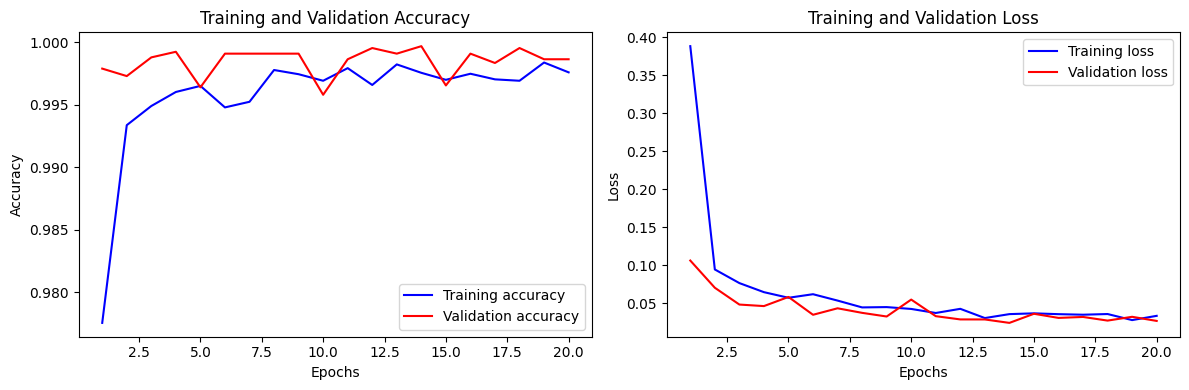

In [ ]:
#Data augmentation
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),tf.keras.layers.RandomRotation(0.1),])

#Displaying the images
# def plot_images(images, labels, title=""):
#     plt.figure(figsize=(12, 10))
#     for i in range(min(20, len(images))):
#         plt.subplot(4, 5, i + 1)
#         plt.imshow(images[i])
#         plt.title(f'Label: {labels[i]}')
#         plt.axis('off')
#     plt.suptitle(title)
#     plt.show()

#Training data
# for x_train_batch, y_train_batch in train_set.take(1):
#     #Applying data augmentation to the training set
#     x_train_batch = data_augmentation(x_train_batch)
#     plot_images(x_train_batch, y_train_batch, title="Training Images")

#Validation Data
# for x_val_batch, y_val_batch in validation_set.take(1):
#     plot_images(x_val_batch, y_val_batch, title="Validation Images")

# Defining the input shape
input_shape = (224, 224, 3) # image size of 224x224 with 3 color channels

# Creating the base model
base_model = ResNet50V2(
    include_top=False,
    weights="imagenet", # Using the pretrained imagenet 
    input_shape=input_shape
)

# Freezing the base model
base_model.trainable = False

# New model - custom top layers
inputs = Input(shape=input_shape)
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu',kernel_regularizer=l2(0.01))(x)
outputs = Dense(2, activation='softmax')(x)

# Creating the final model
final_model = Model(inputs=inputs, outputs=outputs)

# Compiling the model
final_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#Final model
history = final_model.fit(train_set, validation_data=validation_set, epochs=20,
         callbacks =[tf.keras.callbacks.ModelCheckpoint('my_model.keras', save_best_only=True)])
                     #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

#Summary
#final_model.summary()

# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    #Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    #Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting the training metrics after training
plot_training_history(history)


In [54]:
train_accuracy = history.history['accuracy']  
validation_accuracy = history.history['val_accuracy'] 

avg_train_accuracy = float(np.mean(train_accuracy))
avg_val_accuracy = float(np.mean(validation_accuracy))

print(f"Average Training Accuracy: {avg_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {avg_val_accuracy :.4f}")

Average Training Accuracy: 0.9958
Average Validation Accuracy: 0.9985


In [55]:
# Evaluateing on test set
model = tf.keras.models.load_model('/kaggle/input/my_model/keras/default/1/my_model.keras')
test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

262/262 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 1.0000 - loss: 1.3529e-04
Test accuracy: 0.9999
Test loss: 0.0004


In [56]:
# Precision, recall, and F1 score
precision = precision_score(test_labels, test_predictions, pos_label=1)
recall = recall_score(test_labels, test_predictions, pos_label=1)  
f1 = f1_score(test_labels, test_predictions, pos_label=1)

# Calculating test accuracy
test_accuracy = np.mean(test_predictions == test_labels)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 1.0000
Recall: 0.9998
F1 Score: 0.9999


Text(0.5, 1.0, 'Confusion Matrix')

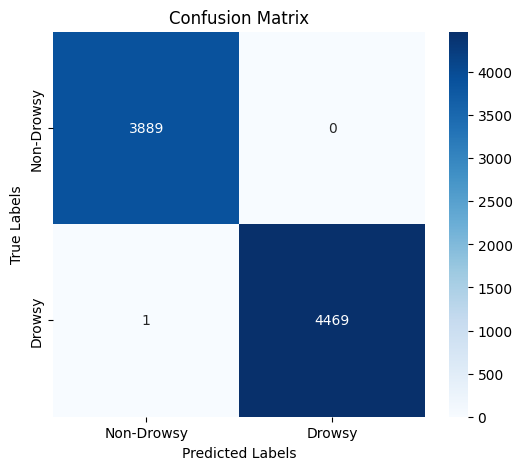

In [57]:
#Calculating the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Non-Drowsy', 'Drowsy'], yticklabels=['Non-Drowsy', 'Drowsy'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
